<a href="https://colab.research.google.com/github/quxiaojing1985/mytvmpractice/blob/main/endtoend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels


In [62]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
import numpy as np
from tvm import relax
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

In [63]:
import IPython

def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.lexers import Python3Lexer
    from pygments.formatters import HtmlFormatter
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

In [64]:
from torchvision.datasets.mnist import FashionMNIST
import torchvision
import torch
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download = True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
img,label = next(iter(test_loader))
img =  img.reshape(1, 28, 28).numpy()


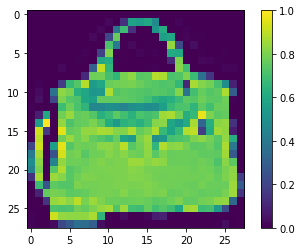

Class: Bag


In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [65]:
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-08-11 03:52:14--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-08-11 03:52:15--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl.1’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.03s   

2022-08-11 03:52:15 (12.6 MB/s) - ‘fasionmnist_mlp_params

In [66]:
def numpy_mlp(data, w0, b0, w1, b1):
  lv0 = data @ w0.T + b0
  lv1 = np.maximum(lv0, 0)
  lv2 = lv1 @ w1.T + b1
  return lv2

In [67]:
import pickle as pkl
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind =res.argmax(axis=1)
print(pred_kind)
print("Numpy-MLP predictiona:", class_names[pred_kind[0]])

[[ 12.250845  -15.41249   -12.577083   -3.7667994 -19.052595  -31.424759
    1.3092998 -40.09615   -21.486423  -36.833054 ]]
[0]
Numpy-MLP predictiona: T-shirt/top


In [68]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z:np.ndarray):
  Y = np.empty((1, 128), dtype = "float32")
  for i in range(1):
    for j in range(128):
      for k in range(784):
        if k == 0:
          Y[i, j] = 0
        Y[i, j] = Y[i, j] + X[i, k]*W[j,k]
  for i in range(1):
    for j in range(128):
      Z[i, j] = Y[i, j] + B[j]
def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
  for i in range(1):
    for j in range(128):
      Y[i, j] = np.maximum(X[i, j], 0)
def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z:np.ndarray):
  Y = np.empty((1, 10), dtype = "float32")
  for i in range(1):
    for j in range(10):
      for k in range(128):
        if k == 0:
          Y[i, j] = 0
        Y[i, j] = Y[i, j] + X[i, k]*W[j,k]
  for i in range(1):
    for j in range(10):
      Z[i, j] = Y[i, j] + B[j]

def lnumpy_mlp(data, w0, b0, w1, b1):
  lv0 = np.empty((1, 128), dtype = "float32")
  lnumpy_linear0(data, w0, b0, lv0)

  lv1 = np.empty((1,128), dtype="float32")
  lnumpy_relu0(lv0, lv1)

  out = np.empty((1, 10), dtype = "float32")
  lnumpy_linear1(lv1, w1, b1, out)
  return out
result = lnumpy_mlp(
      img.reshape(1, 784),
      mlp_params["w0"],
      mlp_params["b0"],
      mlp_params["w1"],
      mlp_params["b1"]
  )
pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: T-shirt/top


In [136]:
@tvm.script.ir_module
class MyModule:
  @T.prim_func
  def relu0(X: T.Buffer[(1, 128), "float32"],
            Y: T.Buffer[(1, 128), "float32"]):
    T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
    for i, j in T.grid(1, 128):
      with T.block("Y"):
        vi,vj = T.axis.remap("SS", [i,j])
        Y[vi, vj] = T.max(X[vi,vj], T.float32(0))

  @T.prim_func
  def linear0(X: T.Buffer[(1, 784), "float32"],
              W: T.Buffer[(128, 784), "float32"],
              b: T.Buffer[(128,), "float32"],
              Z: T.Buffer[(1, 128), "float32"]):
    T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
    Y = T.alloc_buffer((1, 128), "float32")
    for i, j, k in T.grid(1, 128, 784):
      with T.block("Y"):
        vi, vj, vk = T.axis.remap("SSR", [i, j, k])
        with T.init():
          Y[vi, vj] = T.float32(0)
        Y[vi,vj] = Y[vi,vj] + X[vi, vk] *W[vj, vk]

    for i, j in T.grid(1, 128):
      with T.block("Z"):
        vi, vj = T.axis.remap("SS", [i,j])
        Z[vi, vj] = Y[vi, vj] + b[vj]

  @T.prim_func
  def linear1(X: T.Buffer[(1, 128), "float32"],
                W: T.Buffer[(10, 128), "float32"],
                b: T.Buffer[(10,), "float32"],
                Z: T.Buffer[(1, 10), "float32"]):
    T.func_attr({"global_symbol" : "linear1", "tir.noalias": True})  
    Y =  T.alloc_buffer((1, 10), "float32")
    for i, j, k in T.grid(1, 10, 128):
      with T.block("Y"):
        vi, vj, vk =  T.axis.remap("SSR", [i,j,k])
        with T.init():
          Y[vi, vj] = T.float32(0)
        Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

    for i, j in T.grid(1, 10):
      with T.block("Z"):
        vi, vj = T.axis.remap("SS", [i,j])
        Z[vi,vj] = Y[vi, vj] + b[vj]

  @R.function
  def main(x: Tensor((1, 784), "float32"),
           w0: Tensor((128, 784), "float32"),
           b0: Tensor((128,), "float32"),
           w1: Tensor((10, 128), "float32"),
           b1:Tensor((10,),"float32")):
    with R.dataflow():
      lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
      lv1 = R.call_tir(relu0, (lv0, ), (1, 128), dtype = "float32")
      out = R.call_tir(linear1, (lv1,w1, b1), (1, 10), dtype = "float32")
      R.output(out)
    return out


In [131]:
def lnumpy_call_tir(prim_func, inputs, shape, dtype):
  res = np.empty(shape, dtype = dtype)
  prim_func(*inputs, res)
  return res
  

In [132]:
def lnumpy_mlp_with_call_tir(data, w0, b0, w1, b1):
    lv0 = lnumpy_call_tir(lnumpy_linear0, (data, w0, b0), (1, 128), dtype="float32")
    lv1 = lnumpy_call_tir(lnumpy_relu0, (lv0, ), (1, 128), dtype="float32")
    out = lnumpy_call_tir(lnumpy_linear1, (lv1, w1, b1), (1, 10), dtype="float32")
    return out

result = lnumpy_mlp_with_call_tir(
    img.reshape(1, 784), 
    mlp_params["w0"], 
    mlp_params["b0"], 
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = np.argmax(result, axis=1)
print("Low-level Numpy with CallTIR Prediction:", class_names[pred_kind[0]])

Low-level Numpy with CallTIR Prediction: T-shirt/top


In [150]:
@tvm.register_func("env.linear", override = True)
def torch_linear(x:tvm.nd.NDArray,
                 w:tvm.nd.NDArray,
                 b:tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
  x_torch = torch.from_dlpack(x)
  w_torch = torch.from_dlpack(w)
  b_torch =  torch.from_dlpack(b)
  out_torch = torch.from_dlpack(out)
  torch.mm(x_torch, w_torch.T, out = out_torch)
  torch.add(out_torch, b_torch, out =  out_torch)

@tvm.register_func("env.relu", override=True)
def torch_relu(x:tvm.nd.NDArray,
                  out:tvm.nd.NDArray):
  x_torch =  torch.from_dlpack(x)
  out_torch = torch.from_dlpack(out)
  torch.maximum(x_torch, torch.Tensor([0.0]), out = out_torch)

In [151]:
@tvm.script.ir_module
class MyModuleWithExternCall2:
  @R.function
  def main(x: Tensor((1,784), "float32"),
           w0: Tensor((128, 784), "float32"),
           b0: Tensor((128,), "float32"),
           w1: Tensor((10, 128), "float32"),
           b1: Tensor((10,), "float32")):
      with R.dataflow():
             lv0 = R.call_tir("env.linear", (x, w0, b0), (1, 128), dtype="float32")
             lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype = "float32")
             out = R.call_tir("env.linear", (lv1, w1, b1), (1,10), dtype="float32")
             R.output(out)
      return out

In [152]:
ex = relax.vm.build(MyModuleWithExternCall2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd, 
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithExternCall Prediction:", class_names[pred_kind[0]])

MyModuleWithExternCall Prediction: T-shirt/top
